In [38]:
import pandas as pd
import numpy as np
import datetime
import pytz

from MakeSens import MakeSens
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc('text',usetex=True)
plt.rc('font',size=16)

In [2]:
#fecha_inicio = "2023-06-11 00:00:00"
#fecha_fin = "2023-06-18 00:00:00"

# Rango de fecha
fechaFin = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia
#fechaInicio = fechaFin[:-8]+f'{int(fechaFin[-8:-6])-1:02}'+fechaFin[-6:] # Restar una hora

past_date =  datetime.datetime.now(pytz.timezone('America/Bogota'))- datetime.timedelta(days=6)  #Restar 6 días
fechaInicio = past_date.strftime('%Y-%m-%d %H:%M:%S')

Estaciones = [('E2_00023','Grupo Halley',7.1393716,-73.1210968),
            ('mE1_00004','Col. Tecnologico',7.1381572,-73.1180935),
            ('mE1_00005','Col. Santander',7.1385332,-73.121327),
            ('mE1_00007','Col. Normal',7.1277056,-73.116534),
            ('mE1_00006','Col. Pilar',7.108717813305484, -73.12173474310134),
            ('mE1_00008','Col. FundeUis',7.05756, -73.0912)]

frecuencia = "m"

#Descargamos los datos de MakeSens

In [3]:
wd = 30
ped = int(wd*0.1) 

def hour_mean(est):
    global pm25
    data = MakeSens.download_data(est, fechaInicio, fechaFin, frecuencia)
    
    if not data.empty:
        pm25 = data[["pm25_1", "pm25_2"]].copy(deep=True)
        pm25.index = pd.to_datetime(pm25.index) #Convertimos el indice a formato fecha
        
        pm25.pm25_1 = pm25.pm25_1.where(pm25.pm25_1 < 120, np.nan)
        pm25.pm25_2 = pm25.pm25_2.where(pm25.pm25_2 < 120, np.nan)
        
        pm25['pm25_1_r'] = pm25['pm25_1'].rolling(window=wd, min_periods=ped).mean() 
        pm25['pm25_2_r'] = pm25['pm25_2'].rolling(window = wd,min_periods=ped).mean()
        
        pm25['hour'] = pm25.index.hour
        
        hourly_1 = pm25.pm25_1_r.groupby(pm25.hour).mean()
        hourly_2 = pm25.pm25_2_r.groupby(pm25.hour).mean()
        
        data_final = ((hourly_1+hourly_2)/2.0).to_frame()
        
    else:
        pm25 = data
        data_final = data
    
    return data_final

In [4]:
Week = {
  1: "Lunes",
  2: "Martes",
  3: "Miercoles",
  4: "Jueves",
  5: "Viernes",
  6: "Sabado",
  7: "Domingo"
}
Ntotal = int(24*30)

def day_mean(data,j):
    
    if not data.empty:
        data.dropna()
        pm25['day'] = pm25.index.day
        dfw = [ g for _,g in  data.groupby(data.day)]
        
        NN = len(dfw)
        pm25_grid = np.zeros(NN)
        day = []
        for i in range(NN):
            Ndata = dfw[i]['pm25_1'].count()
            day_p = dfw[i].index.isocalendar().day[0]
            
            number = dfw[i].day[0]
            day.append( "_".join([Week[day_p], str(number)]) )
            
            if Ndata>0.5*Ntotal:     
                pm25_grid[i] = np.mean([dfw[i]['pm25_1'].mean(),dfw[i]['pm25_2'].mean()])
            else:
                pm25_grid[i] = np.nan
                
        df2 = pd.DataFrame( [ np.array(pm25_grid) ],
                           columns=day)
        
        df2 = df2.set_index( pd.Index( [ Estaciones[j][1] ] ) )
    
    else:
        df2 = data
    
    return  df2

In [5]:
hr_0 = hour_mean(Estaciones[0][0])
hr_0.columns = [Estaciones[0][1]]

day_0 = day_mean(pm25,0)
#day_0 = day_0.set_index( pd.Index( [ Estaciones[0][1] ] ) )
#day_0.head()

In [6]:
Nest=len(Estaciones)

for i in range(1,Nest):
    print(Estaciones[i][1])
    hr_1 = hour_mean( Estaciones[i][0] )
    day_1 = day_mean(pm25,i)
    
    if not hr_1.empty:
        hr_1.columns = [ Estaciones[i][1] ] 
        hr_0 = hr_0.join(hr_1)
    
    if not day_1.empty:
        #day_1 = day_1.set_index( pd.Index( [ Estaciones[i][1] ] ) )
        #day_0  = day_0.reset_index()
        #day_1  = day_1.reset_index()
        day_0 = pd.concat([day_0, day_1])


Col. Tecnologico
Col. Santander
Col. Normal
Col. Pilar
Col. FundeUis


In [7]:
df_all_transposed = hr_0.transpose()

In [8]:
df_all_transposed.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Grupo Halley,17.345352,21.920648,19.762659,15.507630,13.677130,16.454611,12.781463,16.620407,18.211564,16.414749,...,34.409104,36.736290,22.736950,20.456030,16.121386,16.299000,20.054942,25.611120,21.320431,19.562899
Col. Tecnologico,9.656513,11.221373,11.494737,11.396708,10.880077,10.276923,9.425670,8.811628,8.966475,8.793040,...,11.202222,13.958333,15.450562,14.041279,12.819192,11.279841,10.969048,10.495788,11.860292,11.314757
Col. Normal,15.002846,15.874612,18.974031,17.327395,13.057491,13.832946,12.070238,10.973725,11.876389,12.534644,...,23.424521,25.625235,17.695344,13.767978,13.387302,12.390036,13.835441,16.275182,14.963805,15.201163
Col. Pilar,10.896886,11.119035,12.820870,14.277778,13.484457,12.482197,13.807326,17.817943,22.108197,14.948687,...,17.396255,13.176326,11.374725,11.195644,10.908333,8.646255,10.273519,12.617362,11.983971,11.347191
Col. FundeUis,NaN,7.100000,7.066667,NaN,6.786667,NaN,NaN,NaN,5.293333,NaN,...,23.084230,25.094444,16.892241,12.904412,10.775425,9.201961,6.573016,5.882843,6.828889,NaN


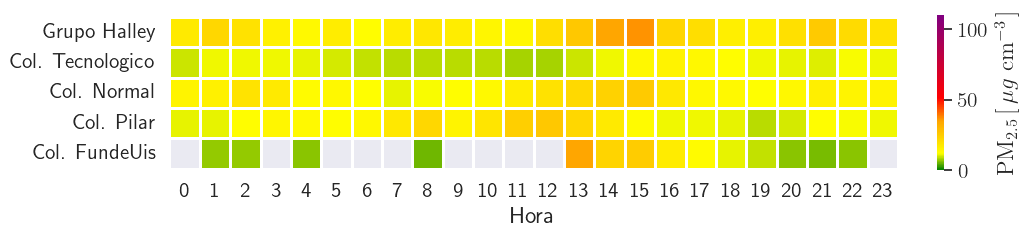

In [40]:
from matplotlib.colors import LinearSegmentedColormap

#cvals  = [6,12,37, 55, 100]
cvals  = [0,13, 38, 56, 120]
#colors = ['green', "#c8ff00", 'yellow', 'orange', "red"]
colors = ['green',  'yellow', 'orange', "red", "purple"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list('name', tuples)
#cmap = ListedColormap(colors)

sns.set(font_scale=1.4)

plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.heatmap(df_all_transposed,cmap=cmap,square=True, linewidths=2, vmin=0, vmax=110,
           cbar_kws={'fraction' : 0.01, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})

plt.yticks(rotation=0) 
plt.xlabel('Hora')

plt.show()

In [10]:
day_0.head()

,Martes_20,Miercoles_21,Jueves_22,Viernes_23,Sabado_24,Domingo_25,Lunes_26
Grupo Halley,NaN,20.603138,22.664321,13.893075,NaN,NaN,NaN
Col. Tecnologico,NaN,12.619621,13.318408,7.784641,NaN,NaN,NaN
Col. Normal,NaN,16.628488,18.439592,11.814554,NaN,NaN,NaN
Col. Pilar,NaN,15.405815,15.042485,13.671935,NaN,NaN,NaN
Col. FundeUis,NaN,NaN,NaN,NaN,NaN,NaN,NaN


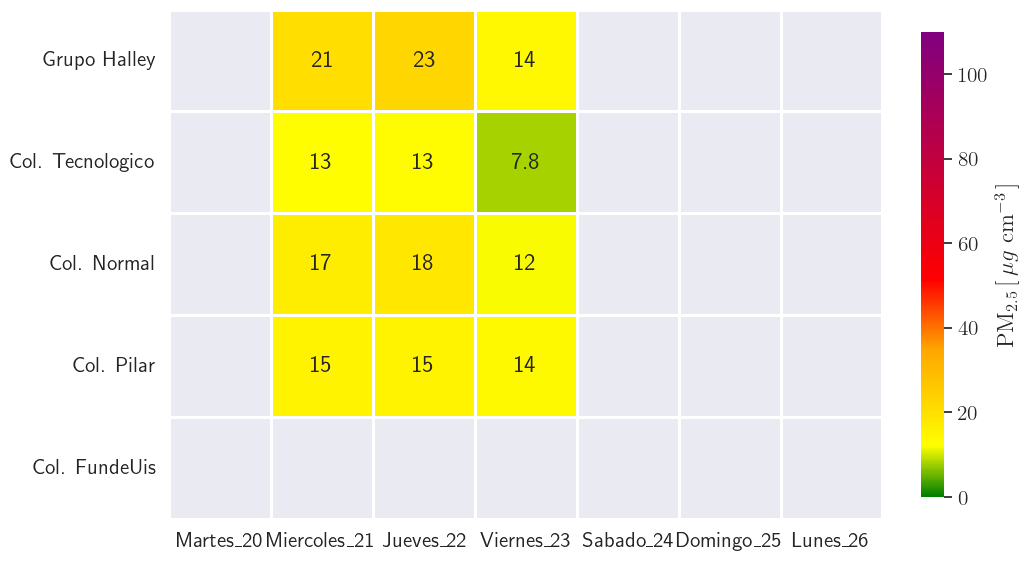

In [47]:
plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.heatmap(day_0,cmap=cmap,square=True,linewidths=2, vmin=0, vmax=110, annot=True,
           cbar_kws={'fraction' : 0.03, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})


sns.set(font_scale=1.2)

plt.yticks(rotation=0) 
#plt.xlabel('Hora')

plt.show()